# Staff Scheduling in Retail

In [1]:
from gurobipy import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scp

In [2]:
#PARAMETERS
OT = 10        # Opening time of store
CT = 22        # Closing time of store
pfrate = 0.3   # Allowed ratio of part-time to total staff (part-time/(part-time + full-time))
FG = 40        # Allowable gross work hours per week for full-time staff
FD = 5         # Allowable workdays per week for full-time staff
PG = 30        # Allowable gross work hours per week for part-time staff
PD = 4         # Allowable workdays per week for part-time staff
CostF = 15     # Hourly cost of a full-time staff member to the store
CostP = 9      # Hourly of a part-time staff member to the store

#The following matrix describes the structure of shifts. Each row represents a shift.
#Each column represents an hour in the day, from 10 am to 10 pm.
#There is a 1 if the employee work at that time, and a 0 otherwise. 
schedule_matrix = np.array(
                  [[1,1,1,0,1,1,1,0,0,0,0,0], # 10-17, len = 7, b =13
                   [1,1,1,1,0,1,1,1,1,0,0,0], # 10-19, len = 9, b = 14
                   [1,1,1,1,1,0,1,1,1,0,0,0], # 10-19, len = 9, b = 15
                   [1,1,1,1,0,1,1,0,1,0,0,0], # 10-19, len = 9, b = 17
                   [1,1,1,1,0,1,1,0,1,1,1,0], # 10-21, len = 11, b = 14
                   [1,1,1,1,1,0,1,1,1,1,1,0], # 10-21, len = 11, b = 15
                   [1,1,1,1,0,1,1,1,1,1,1,1], # 10-22, len = 12, b = 14
                   [1,1,1,1,1,0,1,1,1,1,1,1], # 10-22, len = 12, b = 15
                   [1,1,1,1,1,1,0,1,1,1,1,1], # 10-22, len = 12, b = 16
                   [0,1,1,1,0,1,1,1,1,0,0,0], # 11-19, len = 8, b = 14
                   [0,1,1,1,1,0,1,1,1,0,0,0], # 11-19, len = 8, b = 15
                   [0,1,1,1,1,0,1,1,1,1,0,0], # 11-20, len = 9, b = 15
                   [0,1,1,1,1,0,1,1,1,1,1,1], # 11-22, len = 11, b = 15
                   [0,1,1,1,1,1,0,1,1,1,1,1], # 11-22, len = 11, b = 16
                   [0,1,1,1,1,1,1,0,1,1,1,1], # 11-22, len = 11, b = 17
                   [0,0,1,1,1,1,0,0,0,0,0,0], # 12-16, len = 4, b = 16
                   [0,0,1,1,1,1,0,1,1,0,0,0], # 12-19, len = 7, b = 16
                   [0,0,1,1,1,1,0,1,1,1,1,1], # 12-22, len = 10, b = 16
                   [0,0,1,1,1,1,1,0,1,1,1,1], # 12-22, len = 10, b = 17
                   [0,0,0,1,1,1,1,0,0,0,0,0], # 13-17, len = 4, b = 17
                   [0,0,0,1,1,1,1,0,1,1,1,1], # 13-22, len = 9, b = 17
                   [0,0,0,0,1,1,1,1,0,0,0,0], # 14-18, len = 4, b = 18
                   [0,0,0,0,1,1,1,1,0,1,1,0], # 14-21, len = 7, b = 18
                   [0,0,0,0,1,1,1,1,1,0,1,1], # 14-22, len = 8, b = 18
                   [0,0,0,0,0,1,1,1,1,0,0,0], # 15-19, len = 4, b = 19
                   [0,0,0,0,0,1,1,1,1,0,1,1], # 15-22, len = 7, b = 19
                   [0,0,0,0,0,0,1,1,1,1,0,0], # 16-20, len = 4, b = 20
                   [0,0,0,0,0,0,0,0,1,1,1,1]]) # 18-22, len = 4, b = 22

#Duration of each shift
duration_shift = [7, 9, 9, 9, 11, 11, 12, 12, 12, 8, 8, 9, 11, 11, 11, 4, 7, 10, 10, 4, 9, 4, 7, 8, 4, 7, 4, 4]
num_shifts = len(schedule_matrix)

## Creating the model

In [3]:
def solve_model(hreq, num_full, num_part): 
    model = Model("RetailScheduling")
    model.Params.timeLimit = 300.0
    
    #VARIABLES
    assign_full = model.addVars(ifull, days, shifts, vtype = GRB.BINARY, name = "assign_full") 
                    #It's 1 if we assign full-time employee i to shift j on day k, 0 otherwise
    assign_part = model.addVars(ipart, days, shifts, vtype = GRB.BINARY, name = "assign_part")
                    #It's 1 if we assign part-time employee i to shift j on day k, 0 otherwise
    full = model.addVars(ifull, vtype = GRB.BINARY, name = "full") #It's 1 if we hire employee i, 0 otherwise
    part = model.addVars(ipart, vtype = GRB.BINARY, name = "part") #It's 1 if we hire employee i, 0 otherwise
    
    #OBJECTIVE FUNCTION: Minimize total weekly staffing cost
    model.setObjective(assign_full.prod(dict_cost_full) + assign_part.prod(dict_cost_part), GRB.MINIMIZE) 

    #CONSTRAINTS
    #If the employee is not hired, we cannot assign any shift to him.
    model.addConstrs((assign_full.sum(employee, '*', '*') <= 500*full[employee] 
                      for employee in ifull), 'num_full')
    model.addConstrs((assign_part.sum(employee, '*', '*') <= 500*part[employee] 
                      for employee in ipart), 'num_part')
    
    #The proportion of part-time employees cannot be higher than pfrate.
    model.addConstr(part.sum()*(1 - pfrate) <= pfrate*full.sum(), 'pf-ratio')
    
    #No employee can work more than the maximum allowable days per week.
    model.addConstrs((assign_full.sum(employee, '*', '*') <= FD*full[employee]
                      for employee in ifull), 'wdays_full')
    model.addConstrs((assign_part.sum(employee, '*', '*') <= PD*part[employee]
                      for employee in ipart), 'wdays_part')
    
    #No employee can work more than the maximum number of hours allowed in a week.
    model.addConstrs((assign_full.prod(dict_duration, employee, '*', '*') <= FG*full[employee]
                      for employee in ifull), 'max_whours_full')
    model.addConstrs((assign_full.prod(dict_duration, employee, '*', '*') >= PG*full[employee]
                      for employee in ifull), 'min_whours_full')
    model.addConstrs((assign_part.prod(dict_duration, employee, '*', '*') <= PG*part[employee]
                      for employee in ipart), 'max_whours_part')
    
    #Any employee can be assigned to only one shift in any given day.
    model.addConstrs((assign_full.sum(employee, day, '*') <= 1*full[employee] 
                      for employee in ifull for day in days ),'one_shift_day_full')
    model.addConstrs((assign_part.sum(employee, day, '*') <= 1*part[employee]
                      for employee in ipart for day in days ),'one_shift_day_part')
    
    #The staff available in a given day and hour has to meet the demand
    model.addConstrs((assign_full.sum('*', day, np.where(schedule_matrix[:,hour - 10])[0] + 1)
                      + assign_part.sum('*', day, np.where(schedule_matrix[:,hour - 10])[0] + 1) >= hreq[(day,hour)] 
                     for day in days for hour in range(OT, CT)),'meet_demand')
    
    #Breaks symmetry between the variables
    model.addConstrs((full[k] <= full[k - 1] for k in range(2, num_full + 1)),'symmetry_full')
    model.addConstrs((part[k] <= part[k - 1] for k in range(2, num_part + 1)),'symmetry_part')
    
    model.params.outputflag = 0
    model.optimize()
    x = model.getAttr("X",assign_full)
    y = model.getAttr("X",assign_part)
    c = model.objVal
    return x, y, c

In [4]:
def build_schedule(x, y):
    schedule = {}
    for day in days:
        for hour in range(OT, CT):
            num_people = 0
            for shift in shifts:
                if schedule_matrix[shift - 1, hour - 10]:
                    for employee in ifull:
                        if x[(employee, day, shift)] > 0.5:
                            num_people += 1
                        if y[(employee, day, shift)] > 0.5:
                            num_people += 1
            schedule[(day, hour)] = num_people
    return schedule

In [5]:
def service_availability(store_traffic, schedule):
    num_samples = 100000
    simulated_traffic = {hour:np.random.poisson(store_traffic[hour], num_samples)/schedule[hour] 
                         for hour in store_traffic}
    simulated_traffic = np.array(list(simulated_traffic.values()))
    sa_week = [np.sum(sample > 10) for sample in simulated_traffic.transpose()]
    return np.ndarray.flatten(simulated_traffic), np.array(sa_week)

## 1. Using the expected value

In [6]:
#Number of workers required on day i (from 1 - Mon to 7 - Sun), at hour h (from 10 to 21).
hreq = tupledict({
    (1,10):3, (2,10):3, (3,10):3, (4,10):3, (5,10):3, (6,10):3, (7,10):3, 
    (1,11):5, (2,11):5, (3,11):5, (4,11):5, (5,11):5, (6,11):6, (7,11):6, 
    (1,12):7, (2,12):7, (3,12):7, (4,12):7, (5,12):7, (6,12):8, (7,12):8, 
    (1,13):7, (2,13):7, (3,13):7, (4,13):7, (5,13):7, (6,13):9, (7,13):10, 
    (1,14):7, (2,14):7, (3,14):7, (4,14):7, (5,14):7, (6,14):9, (7,14):10, 
    (1,15):7, (2,15):7, (3,15):7, (4,15):7, (5,15):7, (6,15):10, (7,15):10, 
    (1,16):7, (2,16):7, (3,16):8, (4,16):7, (5,16):8, (6,16):10, (7,16):11, 
    (1,17):7, (2,17):8, (3,17):8, (4,17):7, (5,17):8, (6,17):10, (7,17):11, 
    (1,18):7, (2,18):7, (3,18):7, (4,18):7, (5,18):7, (6,18):10, (7,18):10, 
    (1,19):7, (2,19):7, (3,19):7, (4,19):7, (5,19):7, (6,19):10, (7,19):10, 
    (1,20):7, (2,20):7, (3,20):7, (4,20):7, (5,20):7, (6,20):9, (7,20):9, 
    (1,21):7, (2,21):7, (3,21):7, (4,21):7, (5,21):7, (6,21):8, (7,21):8
})

num_full = 15 # maximum number of full-time staff
num_part = 15 # maximum number of part-time staff

In [9]:
store_traffic = {hour:hreq[hour]*10 for hour in hreq}

In [7]:
#INDICES
days = tuple(range(1, 8))                #Index for the day of the week; i = 1,...,7
shifts = tuple(range(1, num_shifts + 1)) #Index for the detailed shift type; s = 1,...,n_DS
hour = tuple(range(OT, CT))              #Index for the hourly time periods during a day; h = OT,...,CT
ifull = tuple(range(1,num_full + 1))     #Index for full-time staff members; k = 1, . . . ,n_F
ipart = tuple(range(1, num_part + 1))    #Index for part-time staff members; l = 1, . . . ,n_P

dict_duration = {(employee, day, shift):duration_shift[shift - 1] 
             for employee in ifull for day in days for shift in shifts}
dict_cost_full = {(employee, day, shift):duration_shift[shift - 1]*CostF
                 for employee in ifull for day in days for shift in shifts}
dict_cost_part = {(employee, day, shift):duration_shift[shift - 1]*CostP
                 for employee in ifull for day in days for shift in shifts}

In [8]:
x, y, c1 = solve_model(hreq, num_full, num_part)
schedule = build_schedule(x,y)

Academic license - for non-commercial use only
Changed value of parameter timeLimit to 300.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100


In [10]:
sa_hour1, sa_week1 = service_availability(store_traffic, schedule)

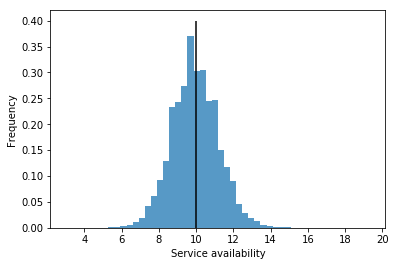

In [11]:
plt.hist(sa_hour1, density = True, bins = 50, alpha = 0.75)
plt.vlines(10, 0, 0.4)
plt.xlabel('Service availability')
plt.ylabel('Frequency')
plt.show()

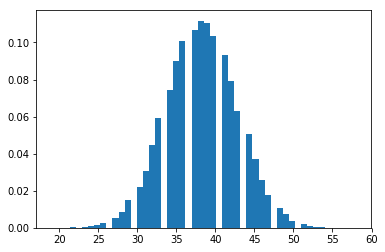

In [12]:
plt.hist(sa_week1, density = True, bins = 50)
plt.show()

In [13]:
#Fraction of hours where I don't meet my target service level
np.sum(sa_hour1 > 10)/len(sa_hour1)

0.4548445238095238

In [14]:
#Fraction of weeks where I don't meet my target service level
1 - np.sum(sa_week1 == 0)/len(sa_week1)

1.0

## Using the quantile of the distribution

In [15]:
#Number of workers required on day i (from 1 - Mon to 7 - Sun), at hour h (from 10 to 21).
hreq = {hour:round(scp.poisson.ppf(0.95, store_traffic[hour])/10,0) for hour in hreq}

num_full = 20 #Maximum number of full-time staff
num_part = 20 #Maximum number of part-time staff

In [16]:
#INDICES
ifull = tuple(range(1,num_full + 1))     #Index for full-time staff members; k = 1, . . . ,n_F
ipart = tuple(range(1, num_part + 1))    #Index for part-time staff members; l = 1, . . . ,n_P

dict_duration = {(employee, day, shift):duration_shift[shift - 1] 
             for employee in ifull for day in days for shift in shifts}
dict_cost_full = {(employee, day, shift):duration_shift[shift - 1]*CostF
                 for employee in ifull for day in days for shift in shifts}
dict_cost_part = {(employee, day, shift):duration_shift[shift - 1]*CostP
                 for employee in ifull for day in days for shift in shifts}

In [17]:
x, y, c2 = solve_model(hreq, num_full, num_part)
schedule = build_schedule(x,y)

Changed value of parameter timeLimit to 300.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100


In [18]:
sa_hour2, sa_week2 = service_availability(store_traffic, schedule)

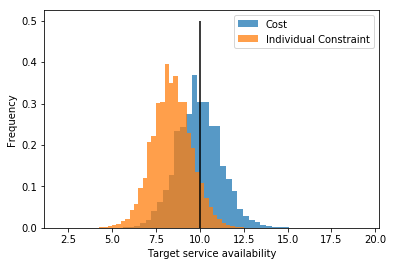

In [19]:
plt.hist(sa_hour1, density = True, bins = 50, alpha = 0.75, label = 'Cost')
plt.hist(sa_hour2, density = True, bins = 50, alpha = 0.75, label = 'Individual Constraint')
plt.vlines(10, 0, 0.5)
plt.xlabel('Target service availability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

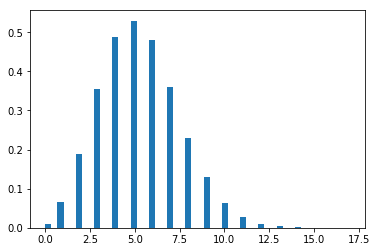

In [20]:
plt.hist(sa_week2, density = True, bins = 50)
plt.show()

In [21]:
#Fraction of hours where I don't meet my target service level
np.sum(sa_hour2 > 10)/len(sa_hour2)

0.06327976190476191

In [22]:
#Fraction of weeks where I don't meet my target service level
1 - np.sum(sa_week2 == 0)/len(sa_week2)

0.9966

## Using the scenario approximation

In [23]:
#Number of workers required on day i (from 1 - Mon to 7 - Sun), at hour h (from 10 to 21).
hreq = {hour:np.ceil(np.max(np.random.poisson(store_traffic[hour],100000)/10)) for hour in hreq}

num_full = 25 #Maximum number of full-time staff
num_part = 25 #Maximum number of part-time staff

In [24]:
#INDICES
ifull = tuple(range(1,num_full + 1))     #Index for full-time staff members; k = 1, . . . ,n_F
ipart = tuple(range(1, num_part + 1))    #Index for part-time staff members; l = 1, . . . ,n_P

dict_duration = {(employee, day, shift):duration_shift[shift - 1] 
             for employee in ifull for day in days for shift in shifts}
dict_cost_full = {(employee, day, shift):duration_shift[shift - 1]*CostF
                 for employee in ifull for day in days for shift in shifts}
dict_cost_part = {(employee, day, shift):duration_shift[shift - 1]*CostP
                 for employee in ifull for day in days for shift in shifts}

In [25]:
x, y, c3 = solve_model(hreq, num_full, num_part)
schedule = build_schedule(x,y)

Changed value of parameter timeLimit to 300.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100


In [26]:
sa_hour3, sa_week3 = service_availability(store_traffic, schedule)

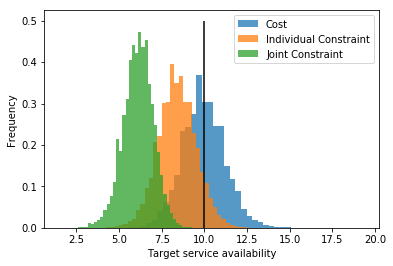

In [27]:
plt.hist(sa_hour1, density = True, bins = 50, alpha = 0.75, label = 'Cost')
plt.hist(sa_hour2, density = True, bins = 50, alpha = 0.75, label = 'Individual Constraint')
plt.hist(sa_hour3, density = True, bins = 50, alpha = 0.75, label = 'Joint Constraint')
plt.vlines(10, 0, 0.5)
plt.xlabel('Target service availability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

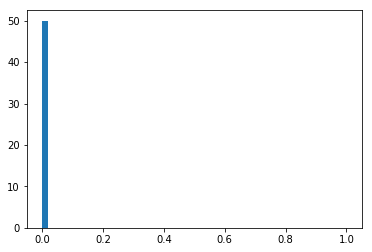

In [28]:
plt.hist(sa_week3, density = True, bins = 50)
plt.show()

In [29]:
#Fraction of hours where I don't meet my target service level
np.sum(sa_hour3 > 10)/len(sa_hour3)

3.2142857142857143e-06

In [30]:
#Fraction of weeks where I don't meet my target service level
1 - np.sum(sa_week3 == 0)/len(sa_week3)

0.00026999999999999247

## Cost as function of service level

In [37]:
num_full = 25 #Maximum number of full-time staff
num_part = 25 #Maximum number of part-time staff

#INDICES
ifull = tuple(range(1,num_full + 1))     #Index for full-time staff members; k = 1, . . . ,n_F
ipart = tuple(range(1, num_part + 1))    #Index for part-time staff members; l = 1, . . . ,n_P

dict_duration = {(employee, day, shift):duration_shift[shift - 1] 
             for employee in ifull for day in days for shift in shifts}
dict_cost_full = {(employee, day, shift):duration_shift[shift - 1]*CostF
                 for employee in ifull for day in days for shift in shifts}
dict_cost_part = {(employee, day, shift):duration_shift[shift - 1]*CostP
                 for employee in ifull for day in days for shift in shifts}

In [38]:
probs = np.insert(np.linspace(0.45, 0.95, 11), 11, [0.99, 0.995])
cost_ind = []
for quantile in probs:  
    print('percentile: ', quantile)
    #Number of workers required on day i (from 1 - Mon to 7 - Sun), at hour h (from 10 to 21).
    hreq = {hour:round(scp.poisson.ppf(quantile, store_traffic[hour])/10,0) for hour in hreq}
    x, y, c = solve_model(hreq, num_full, num_part)
    cost_ind.append(c)

percentile:  0.45
Changed value of parameter timeLimit to 300.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
percentile:  0.5
Changed value of parameter timeLimit to 300.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
percentile:  0.55
Changed value of parameter timeLimit to 300.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
percentile:  0.6
Changed value of parameter timeLimit to 300.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
percentile:  0.65
Changed value of parameter timeLimit to 300.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
percentile:  0.7
Changed value of parameter timeLimit to 300.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
percentile:  0.75
Changed value of parameter timeLimit to 300.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
percentile:  0.8
Changed value of parameter timeLimit to 300.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
percentile:  0.85
Changed value of parameter

In [39]:
#Using the scenario approximation
delta = 0.05
n = 500
cost_joint = []
for quantile in probs:  
    print('percentile: ', quantile)
    epsilon = 1 - quantile
    N = int(round(2/epsilon*np.log(1/delta) + 2*n + 2*n/epsilon*np.log(2/epsilon),0))
    
    #Number of workers required on day i (from 1 - Mon to 7 - Sun), at hour h (from 10 to 21).
    hreq = {hour:np.max(np.random.poisson(store_traffic[hour],N))/10 for hour in hreq}
    
    x, y, c = solve_model(hreq, num_full, num_part)
    cost_joint.append(c)

percentile:  0.45
Changed value of parameter timeLimit to 300.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
percentile:  0.5
Changed value of parameter timeLimit to 300.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
percentile:  0.55
Changed value of parameter timeLimit to 300.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
percentile:  0.6
Changed value of parameter timeLimit to 300.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
percentile:  0.65
Changed value of parameter timeLimit to 300.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
percentile:  0.7
Changed value of parameter timeLimit to 300.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
percentile:  0.75
Changed value of parameter timeLimit to 300.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
percentile:  0.8
Changed value of parameter timeLimit to 300.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
percentile:  0.85
Changed value of parameter

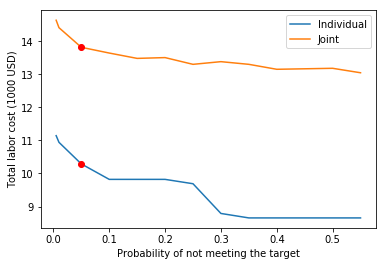

In [40]:
plt.plot(1 - probs, np.array(cost_ind)/1000, label = 'Individual')
plt.plot(1 - probs, np.array(cost_joint)/1000, label = 'Joint')
plt.xlabel('Probability of not meeting the target')
plt.ylabel('Total labor cost (1000 USD)')
plt.legend()
plt.plot([0.05],cost_ind[-3]/1000,'ro')
plt.plot([0.05],cost_joint[-3]/1000,'ro')
plt.show()